In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import time
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, Election
from gerrychain.updaters import cut_edges, Tally
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial

In [2]:
## Run ramdom walk on the shapefile './shapefiles/SC.geojson'
start_time = time.time()

In [3]:
sc_gdf = gpd.read_file("./shapefiles/SC.geojson")
sc_graph = Graph.from_geodataframe(sc_gdf)
print("Nodes info:", sc_graph.nodes()[0])

Nodes info: {'boundary_node': False, 'area': 9926699.65839994, 'COUNTY': '013', 'PCODE': '110', 'CODE_NAME': 'Burton 1A', 'G20PRER': 766, 'G20PRED': 625, 'G20USSRGRA': 747, 'G20USSDHAR': 647, 'TOTPOP': 3780, 'HISP': 524, 'NH_WHITE': 2033, 'NH_BLACK': 862, 'NH_AMIN': 13, 'NH_ASIAN': 108, 'NH_NHPI': 3, 'NH_OTHER': 29, 'NH_2MORE': 208, 'VAP': 2740, 'HVAP': 339, 'WVAP': 1534, 'BVAP': 636, 'AMINVAP': 10, 'ASIANVAP': 81, 'NHPIVAP': 2, 'OTHERVAP': 15, '2MOREVAP': 123, 'CD': '1', 'geometry': <POLYGON ((524841.421 3587457.977, 524851.164 3587434.168, 524853.92 3587422...>}


In [4]:
## Get the congressional district plan from the read-in data
initial_plan = {}
for node, data in sc_graph.nodes(data=True):
    if 'CD' in data:
        initial_plan[node] = data['CD']
print("Congressional District Plan:", initial_plan)

Congressional District Plan: {0: '1', 1: '1', 2: '1', 3: '1', 4: '1', 5: '1', 6: '1', 7: '1', 8: '1', 9: '1', 10: '1', 11: '1', 12: '1', 13: '1', 14: '1', 15: '1', 16: '1', 17: '1', 18: '1', 19: '1', 20: '1', 21: '1', 22: '1', 23: '1', 24: '1', 25: '1', 26: '1', 27: '1', 28: '1', 29: '1', 30: '1', 31: '1', 32: '1', 33: '1', 34: '1', 35: '1', 36: '1', 37: '1', 38: '1', 39: '1', 40: '1', 41: '1', 42: '1', 43: '1', 44: '1', 45: '1', 46: '1', 47: '1', 48: '1', 49: '1', 50: '1', 51: '1', 52: '1', 53: '1', 54: '1', 55: '1', 56: '1', 57: '1', 58: '1', 59: '1', 60: '1', 61: '1', 62: '1', 63: '1', 64: '1', 65: '1', 66: '1', 67: '1', 68: '1', 69: '1', 70: '1', 71: '1', 72: '1', 73: '1', 74: '1', 75: '1', 76: '1', 77: '1', 78: '1', 79: '1', 80: '1', 81: '1', 82: '1', 83: '1', 84: '1', 85: '1', 86: '1', 87: '1', 88: '1', 89: '1', 90: '1', 91: '1', 92: '1', 93: '2', 94: '2', 95: '2', 96: '2', 97: '2', 98: '2', 99: '2', 100: '2', 101: '2', 102: '2', 103: '2', 104: '2', 105: '2', 106: '2', 107: '2', 

In [5]:
initial_partition = Partition(
    sc_graph, 
    assignment=initial_plan,
    updaters={
        "our cut edges": cut_edges,
        "district population": Tally("TOTPOP", alias = "district population"), # across districts, add total population
        "district HISP": Tally("HISP", alias = "district HISP"),
        "votes for democrat - president election": Tally("G20PRED", alias = "votes for democrat - president election"),
        "votes for republic - president election": Tally("G20PRER", alias = "votes for republic - president election"),
        "votes for democrat - senate election": Tally("G20USSDHAR", alias = "votes for democrat - senate election"),
        "votes for republic - senate election": Tally("G20USSRGRA", alias = "votes for republic - senate election"),
    })

In [6]:
print("Initial Partition:", initial_partition)

Initial Partition: <Partition [7 parts]>


In [7]:
## Get the total populaton in South Carolina
tot_pop = sum([sc_graph.nodes()[v]['TOTPOP'] for v in sc_graph.nodes()])
print(tot_pop)

5118425


In [8]:
num_dist = len(initial_partition)
print("Number of districts:", num_dist)
ideal_pop = tot_pop / num_dist
pop_tolerance = 0.01

Number of districts: 7


In [9]:
rw_proposal = partial(recom, ## How we choose a next districting plan
                      pop_col = "TOTPOP", ## The data describes population.
                      pop_target = ideal_pop, ## What the target/ideal population is for each district
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 1 ## number of times to repeat bipartition.
                      )

In [10]:
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition,
    pop_tolerance,
    pop_key="district population")

In [11]:
## Set up the random walk
our_random_walk = MarkovChain(
    proposal = rw_proposal,
    constraints = [population_constraint],
    accept = always_accept, # Accept every proposed plan that meets the population constraints
    initial_state = initial_partition,
    total_steps = 8000)

In [12]:
cutedge_ensemble = [] ## list of number of cut-edges
lmaj_ensemble = []    ## list of number of majority-Latino districts in the plan
democratic_won_districts_ensemble_president_election = []  ## list of number of districts won by Democrat in president election
democratic_won_districts_ensemble_senate_election = []  ## list of number of districts won by Democrat in senate election
total_population = 0

In [13]:
## Run the random walk
for part in our_random_walk:
    # Add cutedges to cutedges ensemble
    cutedge_ensemble.append(len(part['our cut edges']))

    # Calculate number of Latino-majority districts, and add to ensemble
    num_maj_latino = 0
    # Calculate number of districts won by Democrat in the president election, and add to ensemble
    num_democrat_won_districts_president_election = 0
    # Calculate number of districts won by Democrat in the senate election, and add to ensemble
    num_democrat_won_districts_senate_election = 0
    total_population = 0
    for i in range(1, num_dist + 1):
        h_perc = part["district HISP"][str(i)] / part["district population"][str(i)]
        total_population += part["district population"][str(i)]
        if h_perc >= 0.5:
            num_maj_latino = num_maj_latino + 1
        if part["votes for democrat - president election"][str(i)] > part["votes for republic - president election"][str(i)]:
            num_democrat_won_districts_president_election += 1
        if part["votes for democrat - senate election"][str(i)] > part["votes for republic - senate election"][str(i)]:
            num_democrat_won_districts_senate_election += 1
    lmaj_ensemble.append(num_maj_latino)
    democratic_won_districts_ensemble_president_election.append(num_democrat_won_districts_president_election)
    democratic_won_districts_ensemble_senate_election.append(num_democrat_won_districts_senate_election)

In [14]:
print("Number of cut-edges:", cutedge_ensemble)
print("Number of majority-Latino districts:", lmaj_ensemble)
print("Number of districts won by Democrat in the president election:", democratic_won_districts_ensemble_senate_election)
print("Number of districts won by Democrat in the senate election:", democratic_won_districts_ensemble_president_election)
print("Total population in South Carolina:", total_population)

Number of cut-edges: [482, 408, 436, 457, 378, 383, 383, 424, 431, 457, 499, 458, 465, 478, 561, 512, 560, 560, 567, 538, 542, 526, 526, 514, 508, 507, 513, 488, 481, 488, 488, 461, 450, 457, 486, 485, 487, 514, 485, 474, 476, 468, 488, 437, 437, 442, 441, 437, 430, 442, 424, 405, 417, 434, 444, 436, 470, 523, 458, 444, 403, 420, 419, 417, 409, 420, 409, 432, 391, 375, 431, 390, 377, 366, 363, 373, 398, 380, 395, 389, 380, 388, 412, 389, 399, 422, 408, 408, 411, 409, 420, 408, 423, 417, 464, 446, 454, 438, 360, 367, 418, 426, 401, 398, 397, 402, 390, 390, 398, 453, 439, 456, 456, 451, 432, 411, 432, 441, 438, 427, 438, 455, 478, 452, 452, 472, 479, 475, 511, 507, 532, 499, 490, 463, 456, 432, 423, 413, 434, 456, 459, 467, 464, 471, 464, 452, 520, 505, 525, 463, 459, 452, 459, 435, 410, 411, 408, 405, 400, 380, 400, 384, 364, 357, 432, 420, 412, 356, 332, 323, 320, 341, 421, 453, 446, 375, 402, 413, 405, 376, 364, 410, 400, 394, 404, 410, 451, 464, 453, 434, 428, 444, 403, 418, 395, 437

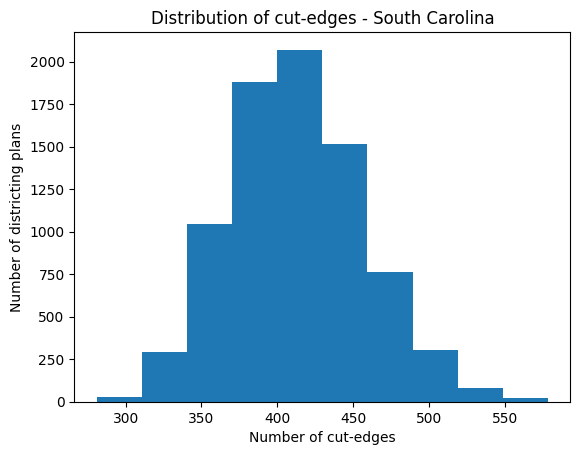

In [15]:
plt.figure()
plt.hist(cutedge_ensemble, align = 'left')
plt.xlabel('Number of cut-edges')
plt.ylabel('Number of districting plans')
plt.title('Distribution of cut-edges')
plt.title('Distribution of cut-edges - South Carolina')
plt.savefig('Distribution of cut-edges - South Carolina')
plt.show()

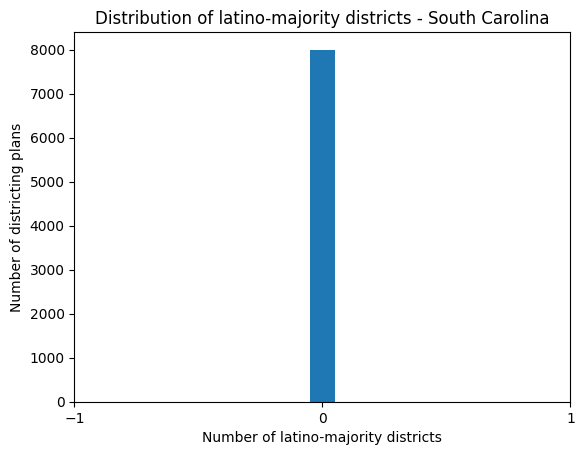

In [16]:
plt.figure()
plt.hist(lmaj_ensemble, align = 'left')
plt.xticks([-1, 0, 1])
plt.xlabel('Number of latino-majority districts')
plt.ylabel('Number of districting plans')
plt.title('Distribution of latino-majority districts - South Carolina')
plt.savefig('Distribution of latino-majority districts - South Carolina')
plt.show()

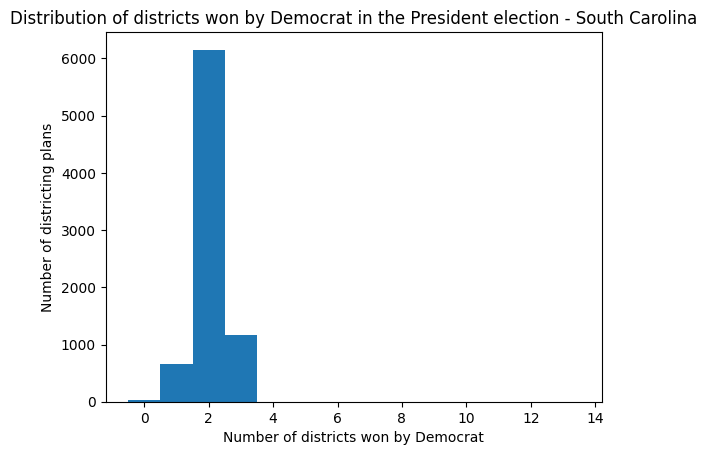

In [17]:
plt.figure()
bins = range(15)
plt.hist(democratic_won_districts_ensemble_president_election, bins = bins, align = 'left')
plt.xlabel('Number of districts won by Democrat')
plt.ylabel('Number of districting plans')
plt.title('Distribution of districts won by Democrat in the President election - South Carolina')
plt.savefig('Distribution of districts won by Democrat in the President election - South Carolina')
plt.show()

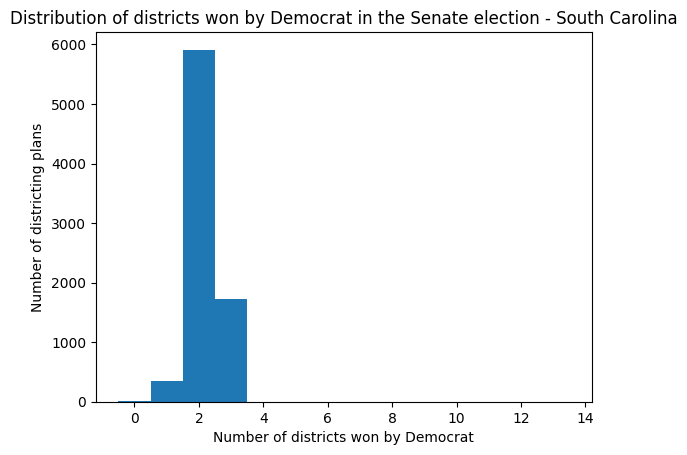

In [18]:
plt.figure()
bins = range(15)
plt.hist(democratic_won_districts_ensemble_senate_election, bins = bins, align = 'left')
plt.xlabel('Number of districts won by Democrat')
plt.ylabel('Number of districting plans')
plt.title('Distribution of districts won by Democrat in the Senate election - South Carolina')
plt.savefig('Distribution of districts won by Democrat in the Senate election - South Carolina')
plt.show()

In [19]:
end_time = time.time()
print("The time of execution of random walk of 8000 steps on South Carolina is :", (end_time-start_time)/60, "mins")

The time of execution of random walk of 8000 steps on South Carolina is : 14.983243163426717 mins
